In [37]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature


In [2]:
data = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/tests/YOIHLQ.zarr/')

In [2]:
path = '/storage/shared/oceanparcels/output_data/data_Claudio/frag_runs/'
file_paths = {'f1000':'HPTJM0.zarr',
                'f1500':'BV8TDP.zarr',
                'f2000':'IHTW7Y.zarr',
                'f2500':'JFS5LH.zarr',
                'f3000':'I1B06F.zarr'}

In [5]:
file_paths['f1000']

'HPTJM0.zarr'

In [9]:
data = xr.open_zarr(path + file_paths['f1000'])

In [10]:
data['w'][:].values

array([[-2.45013565e-04, -1.18485907e-04,  1.33637213e-05, ...,
        -6.75000483e-05,  7.26037979e-06,  2.79478954e-05],
       [-2.45013565e-04, -1.18312877e-04,  1.37874113e-05, ...,
        -8.20904097e-06, -1.78363262e-05, -2.96672697e-05],
       [-2.45013565e-04, -1.18358585e-04,  1.40915636e-05, ...,
         3.43720239e-05,  2.98921896e-05,  1.44349342e-05],
       ...,
       [-2.45013565e-04, -1.18229087e-04,  1.39428412e-05, ...,
        -5.97233557e-05, -8.09804624e-05, -3.68062902e-05],
       [-2.45013565e-04, -1.18327211e-04,  1.37595462e-05, ...,
        -4.00787758e-05, -4.82866672e-05, -2.05342767e-05],
       [-2.45013565e-04, -1.18193886e-04,  1.40906341e-05, ...,
        -2.43278046e-05,  1.19913006e-04,  1.67566017e-04]], dtype=float32)

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([-4.9999994e-01, -3.9999995e-01, -2.9999995e-01, -1.9999994e-01,
        -9.9999949e-02,  5.0000001e-08,  1.0000005e-01,  2.0000005e-01,
         3.0000004e-01,  4.0000004e-01,  5.0000006e-01], dtype=float32),
 <BarContainer object of 10 artists>)

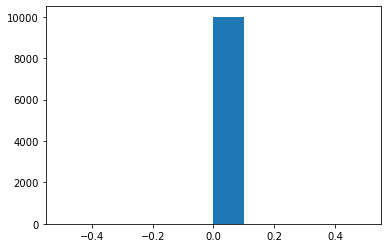

In [19]:
plt.hist(data['diameter'][:, 0])

In [40]:
data

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 1826)
Dimensions without coordinates: traj, obs
Data variables: (12/14)
    Kz                (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    abs_salinity      (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    cons_temperature  (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    density           (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    diameter          (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    lat               (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
    ...                ...
    seafloor          (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    time              (traj, obs) datetime64[ns] dask.array<chunksize=(625, 229), meta=np.ndarray>
    trajectory        (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
    v_s               (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    w                 (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    z                 (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

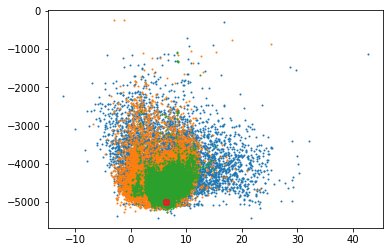

In [36]:
plt.scatter(data['lon'][:, 1800], -data['z'][:, 1800], s=1)
plt.scatter(data['lon'][:, 1000], -data['z'][:, 1000], s=1)
plt.scatter(data['lon'][:, 500], -data['z'][:, 500], s=1)
plt.scatter(data['lon'][:, 0], -data['z'][:, 0])


In [57]:
for n_day in range(1800, 0, -200):
    print(n_day)

1800
1600
1400
1200
1000
800
600
400
200


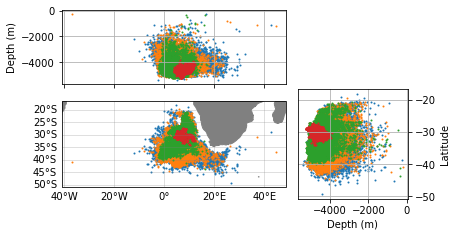

In [64]:
frame = 0
n_day = 1000
size_point = 1
fig = plt.figure(figsize=(6,4))
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Depth (m)')
# ax_lon.set_ylim(-2000, 0)


ax_lat = fig.add_subplot(gs[1, 1])
ax_lat.grid()

# ax_lat.scatter(sim_['abs_salinity'], sim_['cons_temperature'], s=1, c=-sim_['depth']);
# ax_lat.set_xlim(33, max_sal + 1)
ax_lat.yaxis.tick_right()
ax_lat.yaxis.set_label_position("right")
# cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
# cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')

ax_lat.set_xlabel('Depth (m)')
ax_lat.set_ylabel('Latitude')

# size_point = 0.7
for n_day in range(1800, 0, -500):
    im = ax.scatter(data['lon'][:, n_day], data['lat'][:, n_day],  s=size_point)
    ax_lon.scatter(data['lon'][:, n_day], -data['z'][:, n_day], s=size_point)
    ax_lat.scatter(-data['z'][:, n_day], data['lat'][:, n_day], s=size_point);
# # ax_lat.scatter(-sim_['depth'], sim_['lat'], c=-sim_['depth'], s=size_point)

# bar_ax = fig.add_axes([0.12, 0.12, 0.52, 0.05])
# plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Final depth (m)')


In [59]:
1800/365

4.931506849315069

(array([8297.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1673.]),
 array([0.0e+00, 5.0e-09, 1.0e-08, 1.5e-08, 2.0e-08, 2.5e-08, 3.0e-08,
        3.5e-08, 4.0e-08, 4.5e-08, 5.0e-08], dtype=float32),
 <BarContainer object of 10 artists>)

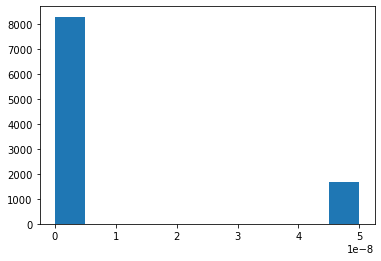

In [21]:
plt.hist(data['diameter'][:, -1])